---
## PEA model simulation (based on single trial learning model from Zhang et al 2024)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import integrate
from scipy.stats import norm
from scipy.special import logsumexp
from statsmodels.nonparametric.smoothers_lowess import lowess

%config InlineBackend.figure_format = "retina"

In [2]:
def pea(x_v, sigma_v, sigma_int, B, T):
    w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    xhat_hand = w_v * x_v
    x_stl = B * (T - xhat_hand)
    return x_stl

def state_totalerr(previous_state, vis_err, A, B, T):
    state_est = A * previous_state + B * (T - vis_err)
    return state_est
    
def state_ege(previous_state, ege, A, B, T):
    state_est = A * previous_state + B * (T - ege)
    return state_est
 

In [3]:
use_tgt_file = False
if use_tgt_file == True:
    # Read in target file used for E1
    df_tgt = pd.read_csv("../inputs/target-files/ige_ege_jump1.csv")
    df_tgt = df_tgt.loc[69:, :].reset_index(drop=True)  # truncate, start w last bsl
    df_tgt["tgt_jump"] = df_tgt["tgt_angle_2"] - df_tgt["tgt_angle_1"]
    # df_tgt = df_tgt.loc[df_tgt["tgt_jump"] == 0, :].reset_index(drop=True)

    delta_x = df_tgt["rotation"]
    vis_fb = df_tgt["online_fb"]
    df_tgt.head()

In [4]:
# Simulated parameters
pert_size = np.array([-4, -2, 0, 2, 4])
n_per_pert = 100
n_per_miniblock = 2
num_trials = len(pert_size) * n_per_pert * n_per_miniblock + 1  # must add one to get correct number of adaptation measures using triplet method
perts = np.repeat(pert_size, n_per_pert)
perts = np.random.permutation(perts)
pert_idx = np.arange(1, num_trials, n_per_miniblock)
prepert_idx = pert_idx - 1
postpert_idx = pert_idx + 1

delta_x = np.zeros(num_trials)
delta_x[pert_idx] = perts

vis_fb_scheds = ["all", "pre pert", "post pert", "none", "mixed"]
vis_fb_sched = "mixed"
vis_fb = np.zeros(num_trials, dtype=bool)
if vis_fb_sched == "all":
    vis_fb = np.ones(num_trials, dtype=bool)
elif vis_fb_sched == "post pert":
    idx = np.sort(np.concatenate((pert_idx, postpert_idx)))
    vis_fb[idx] = 1
elif vis_fb_sched == "none":
    vis_fb[pert_idx] = 1
elif vis_fb_sched == "mixed":
    vis_fb = np.ones(num_trials, dtype="bool")
    idx = np.sort(np.random.choice(prepert_idx, size=int(len(prepert_idx) / 2), replace=False))
    vis_fb[idx] = 0
elif vis_fb_sched == "pre pert":
    idx = np.sort(np.concatenate((pert_idx, prepert_idx)))
    vis_fb[idx] = 1
    
# Simulate using retention factor
use_memory = True

## Intuitions regarding relationship between visual fb and sensitivity of analysis

#### For half null, half perturbation trials
Assuming alternating between null and perturbation trials and no retention of adaptation across trials:
- Having no visual feedback on all null trials results in high sensitivity for detecting adaptation to IGE
    - PEA model and total error learning model show adaptation to IGE (as expected)
    - EGE-only learning model shows no adaptation to IGE (as expected)
- Having visual feedback on all trials results in very zero sensitivity for detecting adaptation to IGE (Bad!)
    - PEA model and total error learning model show no adaptation (a bit of reverse adaptation, in fact) to IGE
    - EGE-only learning model shows no adaptaiton to IGE
- Having no visual feedback on a random mix of trials results in lower sensitivity for detecting adaptation to IGE

With retention:
- With mixed schedule (visual fb on half of null trials, similar to actual protocol), for ege-only learner, there is spurious relationship between IGE and adaptation (this is evidence against there being significant retention, because if there was, we would've seen this spurious correlation between adaptation and IGE!)
- Also, if A is a high value (i.e., > 0.9) you will see an unrealistically wide spread of IGE
- With no visual fb ever on null trials, for EGE learner you tend to see spurious correlation between adaptation and IGE

In [5]:
sigma_motor = 1.8
sigma_int = 7.364
eps = np.random.normal(loc=0, scale=sigma_motor, size=num_trials)  # motor noise
x_stl = np.zeros(num_trials)  # PEA observer
x_hand_pea = np.zeros(num_trials)
x_totalerr = np.zeros(num_trials)  # hand angle of state estimator, learns from total error
x_ege = np.zeros(num_trials)  # hand angle of state estimator, learns from ege only
x_totalerr_mem = np.zeros(num_trials)
x_ege_mem = np.zeros(num_trials)
T = 0
if use_memory == True:
    A = 0.5
else:
    A = 0.0
B = 0.75

# Loop through trials
for i in range(num_trials - 1):
    if i == 0:
        x_hand_pea[i] = eps[i]
        x_totalerr[i] = eps[i]
        x_ege[i] = eps[i]
    
    if vis_fb[i] == 0:
        x_v = 0
        sigma_v = 1e2
        vis_err = 0
        ege = 0
    else:
        x_v = x_hand_pea[i] + delta_x[i]
        sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al
        vis_err = x_totalerr[i] + delta_x[i]
        ege = delta_x[i] 
        
    x_totalerr[i + 1] = state_totalerr(x_totalerr[i], vis_err, A, B, T) + eps[i + 1]
    x_ege[i + 1] = state_ege(x_ege[i], ege, A, B, T) + eps[i + 1]
    x_hand_pea[i + 1] = pea(x_v, sigma_v, sigma_int, B, T) + eps[i + 1]
 

In [6]:
# Adaptation quantified as difference in hand angle post- and pre-perturbation
adapt_pea = np.zeros(num_trials)
adapt_pea[1::n_per_miniblock] = x_hand_pea[2::n_per_miniblock] - x_hand_pea[0:-1:n_per_miniblock]

adapt_ige = np.zeros(num_trials)
adapt_ige[1::n_per_miniblock] = x_totalerr[2::n_per_miniblock] - x_totalerr[0:-1:n_per_miniblock]

adapt_ege = np.zeros(num_trials)
adapt_ege[1::n_per_miniblock] = x_ege[2::n_per_miniblock] - x_ege[0:-1:n_per_miniblock]

# Create data frame with all trials
df_pea = pd.DataFrame({
    "x_hand_pea":x_hand_pea, "x_totalerr":x_totalerr, "x_ege":x_ege, "x_stl":x_stl, 
    "delta_x":delta_x, "adapt_pea":adapt_pea, "adapt_ige":adapt_ige, "adapt_ege": adapt_ege
})
df_pea.sample(5)

,x_hand_pea,x_totalerr,x_ege,x_stl,delta_x,adapt_pea,adapt_ige,adapt_ege
680,-4.417430,-3.876138,-1.791130,0.0,0.0,0.000000,0.000000,0.000000
155,2.055520,4.650835,4.289257,0.0,-2.0,-1.541730,-0.888105,3.142388
28,2.366420,2.376019,3.316922,0.0,0.0,0.000000,0.000000,0.000000
437,-0.819241,0.244177,2.664841,0.0,0.0,-2.121060,-3.144700,-2.082472
791,-1.151327,-0.593465,-0.421872,0.0,-2.0,-2.076815,-2.619145,-1.397878


In [7]:
# Create trimmed data frame without null trials
pea = df_pea.iloc[1::n_per_miniblock].reset_index()
pea.head()

,index,x_hand_pea,x_totalerr,x_ege,x_stl,delta_x,adapt_pea,adapt_ige,adapt_ege
0,1,-2.079883,-2.254967,-2.530460,0.0,4.0,-1.144590,-2.232096,-4.061068
1,3,1.646657,1.223821,-1.640229,0.0,4.0,-0.623541,0.667817,1.982630
2,5,0.938023,-0.027778,-0.284858,0.0,-2.0,0.349357,0.891308,1.256095
3,7,4.402969,3.882822,3.808135,0.0,4.0,-2.840743,-2.916232,0.107915
4,9,4.479969,2.480443,0.950435,0.0,2.0,-0.996822,0.106937,-1.672508


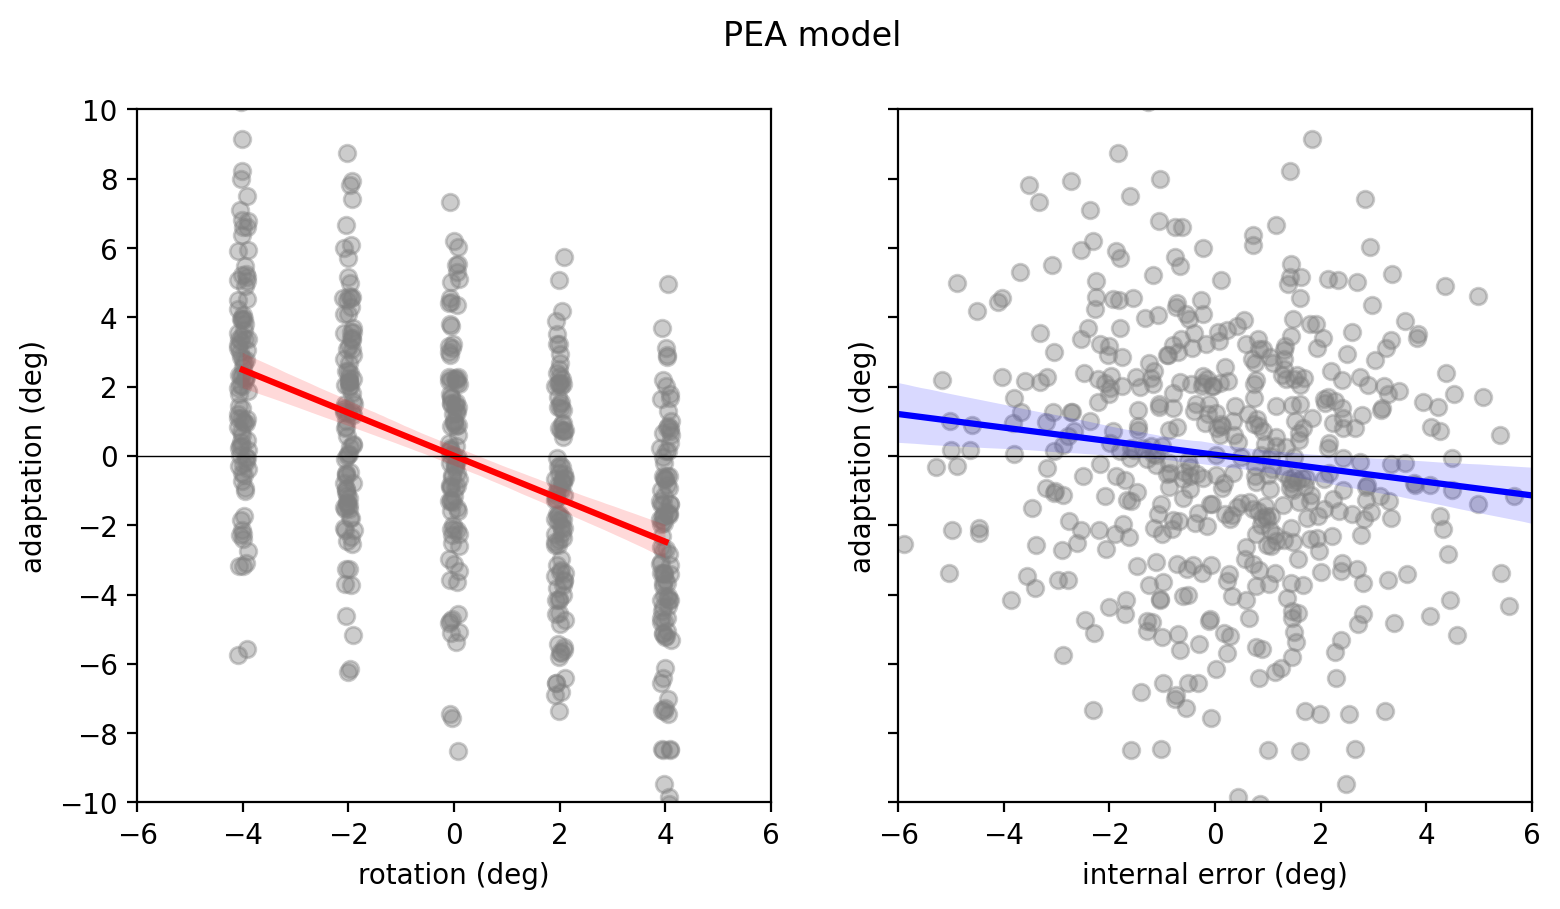

In [8]:
# PEA model
# Plot adaptation to external errors (lowess=True for 'piecewise' fit)
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_pea", 
               scatter_kws={"alpha":0.4, "color":"gray"}, line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_hand_pea", y="adapt_pea", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("PEA model")
# fig.savefig("pea-model-sim.png")

plt.show()

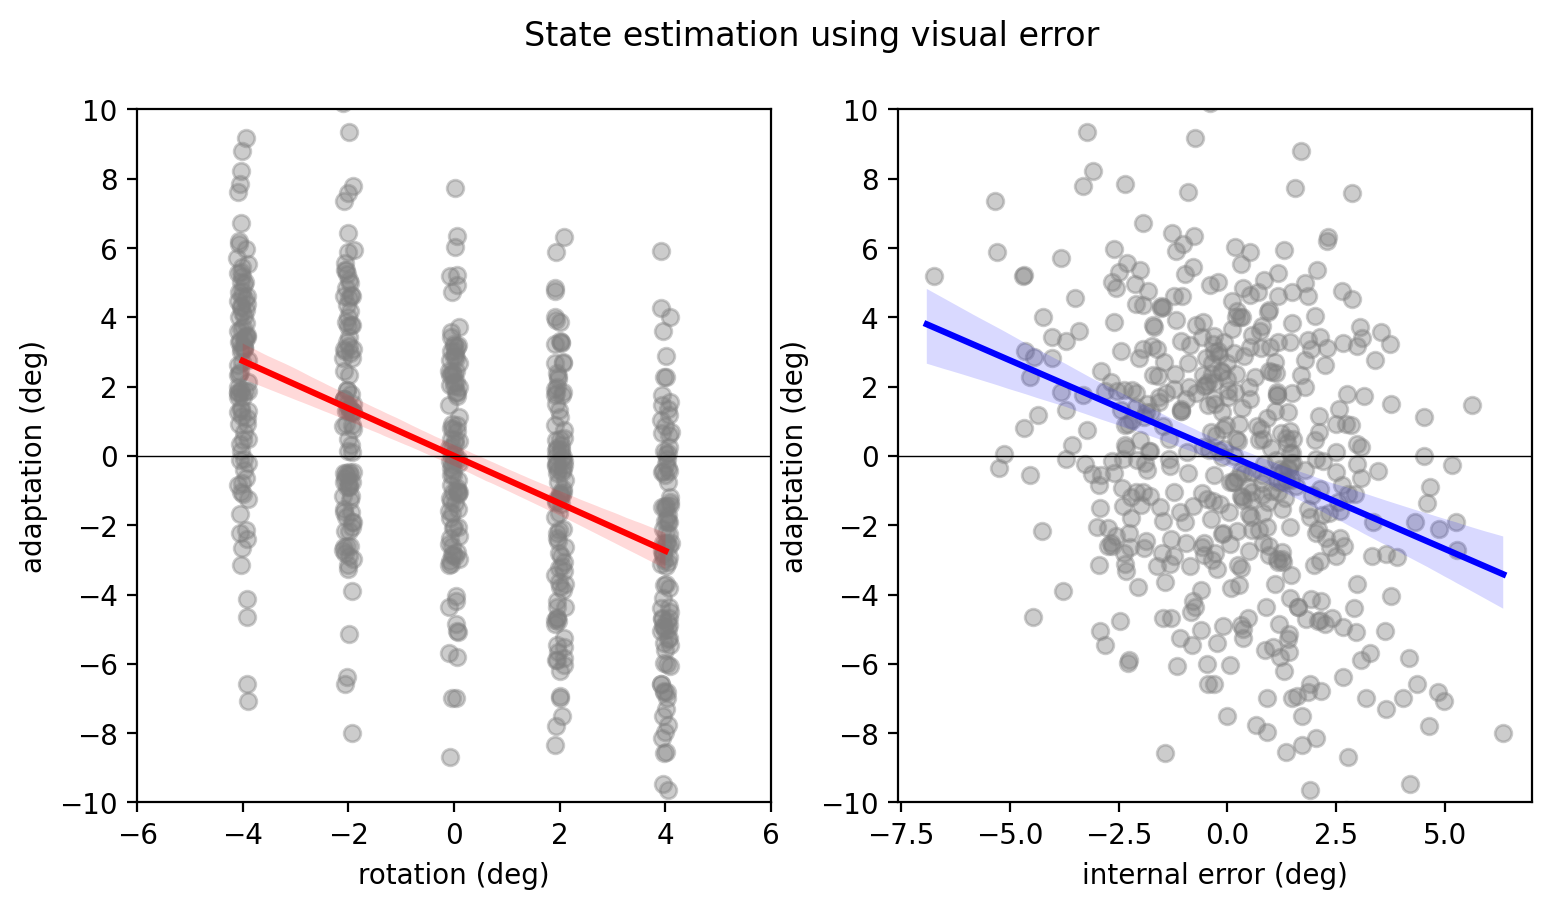

In [9]:
# State estimator (visual learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_ige", 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_totalerr", y="adapt_ige", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("State estimation using visual error")
# fig.savefig("state-est-sim.png")
plt.show()

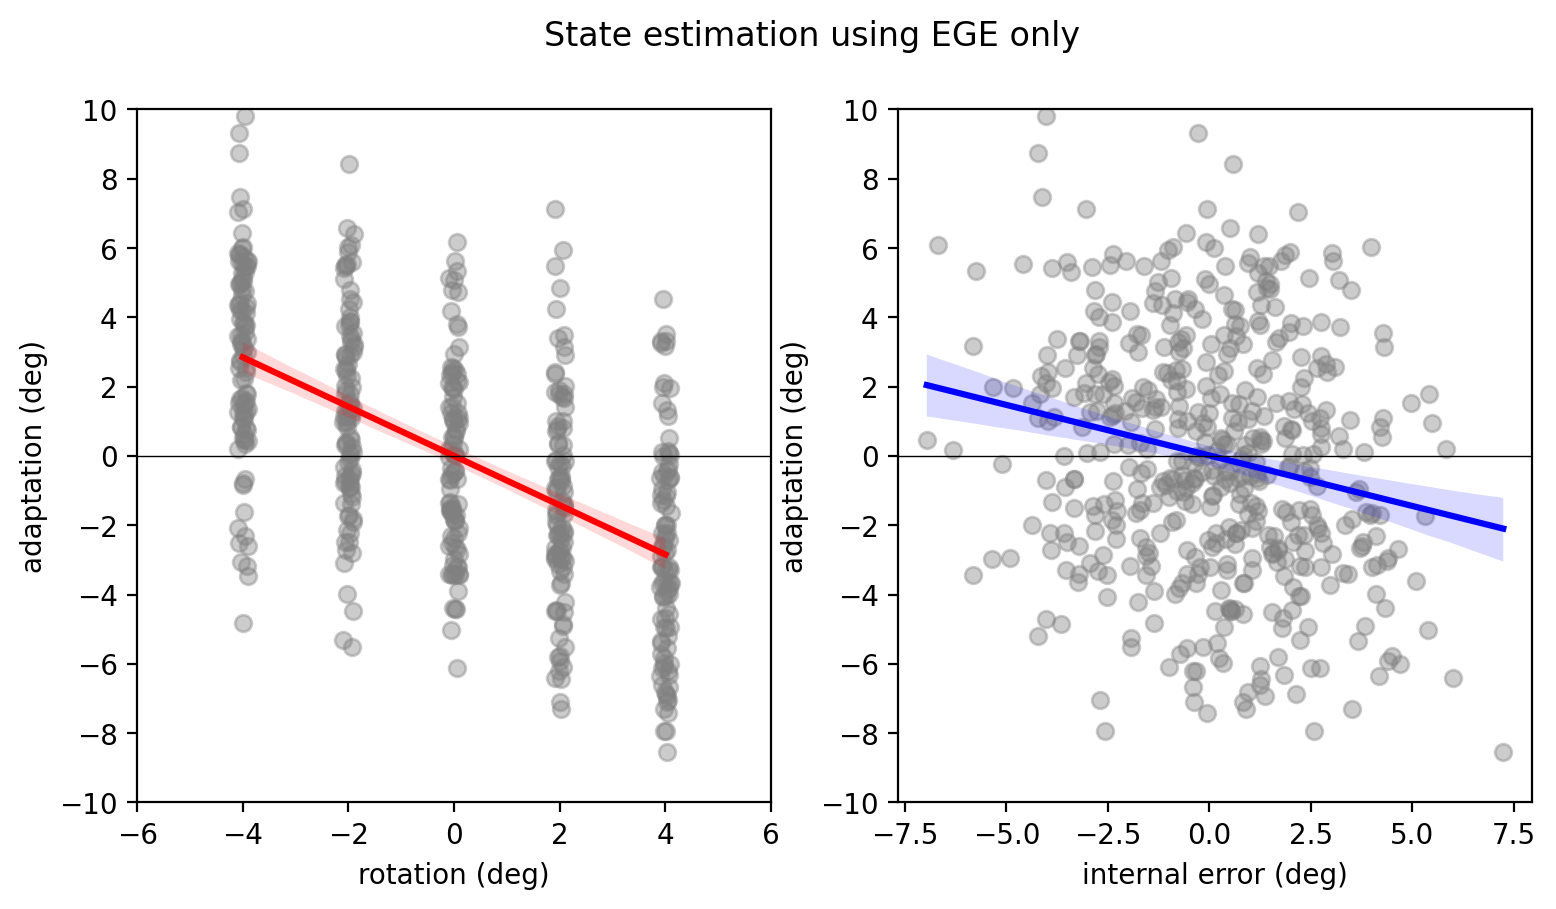

In [10]:
# State estimator (ege learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
sns.regplot(data=pea, x="delta_x", x_jitter=0.1, y="adapt_ege", 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=pea, x="x_ege", y="adapt_ege", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("State estimation using EGE only")
plt.show()